# Base Case: Circular Orbit of Radius 1 AU, Period 1 Year

Create synthetic data for the simplest base case: a circular orbit of radius 1.

Can think of this as approximating the earth: radius = 1 AU, period = 1 year, mass of sun $m_0$ = 1 solar mass

\begin{align}
x(t) &= \cos(\omega t) \\
y(t) &= \sin(\omega t) \\
\omega &= 2 \pi
\end{align}

Taking two derivatives
\begin{align}
\ddot{x}(t) = -\omega^2 x(t)\\
\ddot{y}(t) = -\omega^2 y(t)
\end{align}

Equating the acceleration $\omega^2 r$ to $G \cdot m_0 / r^2$ for $r=1$ in the case of earth, we can see that in these units the gravitational constant $G$ is
$$G = 4 \pi^2$$

Further we can see that for a planet in a circular orbit with radius $r$, the angular frequency will satisfy
$$ \omega^2 = G m_0 / r^3$$
This is a special case of Kepler's third law.

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from r2bc_data import make_traj_r2bc , make_train_r2bc
from r2bc_data import make_datasets_earth, make_datasets_solar, make_datasets_r2bc
from r2b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy

from r2bc import KineticEnergy_R2BC, PotentialEnergy_R2BC
from r2bc import AngularMomentum0_R2BC, AngularMomentum_R2BC
from r2bc import ConfigToPolar2D
from r2bc import Motion_R2BC
from r2b import VectorError, EnergyError, AngularMomentumError

from r2bc_model_math import make_position_model_r2bc_math, make_model_r2bc_math
from r2bc_model_nn import make_position_model_r2bc_nn# , make_physics_model_r2bc_nn
from r2bc_model_nn import make_model_r2bc_nn, compile_and_fit
from r2bc_model_nn import plot_orbit_nn_q

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Load the tensorboard extension to monitor training
%load_ext tensorboard

In [5]:
# Create distribution strategy
# This isn't working properly for training in Michael-PC (Windows 10)
# but does work for evaluating (with no real benefit though)
# strat = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1'])

# Plot style 
plot_style()

In [6]:
# Lightweight serialization
fname = '../data/r2b/r2bc.pickle'
vartbl = load_vartbl(fname)

In [7]:
# One trajectory of earth for plotting
inputs_earth, outputs_earth = make_traj_r2bc(r0=1.0, theta0=0.0, n_years=2)

# Combined dict
data_earth = {**inputs_earth, **outputs_earth}

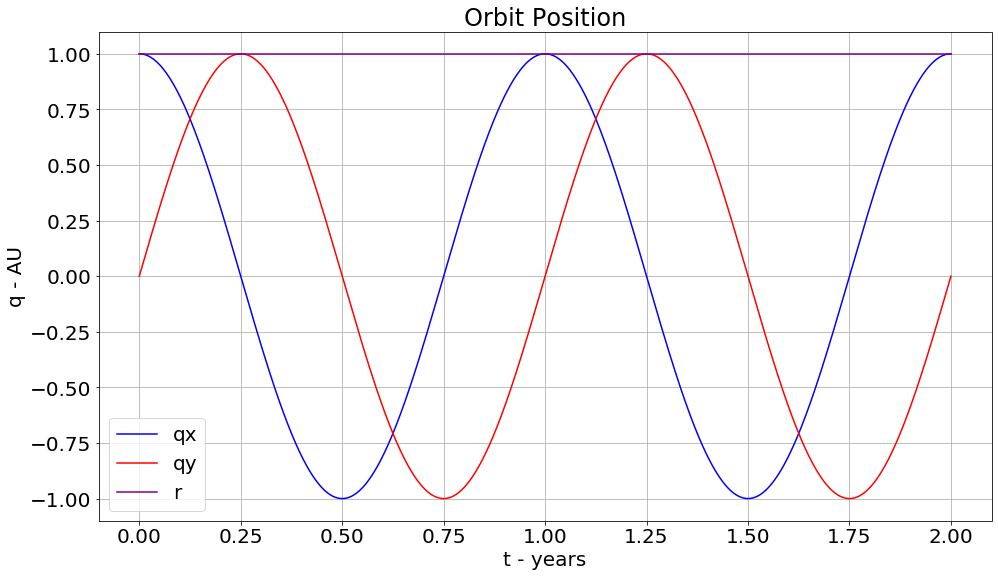

In [8]:
fig, ax = plot_orbit_q(data_earth)

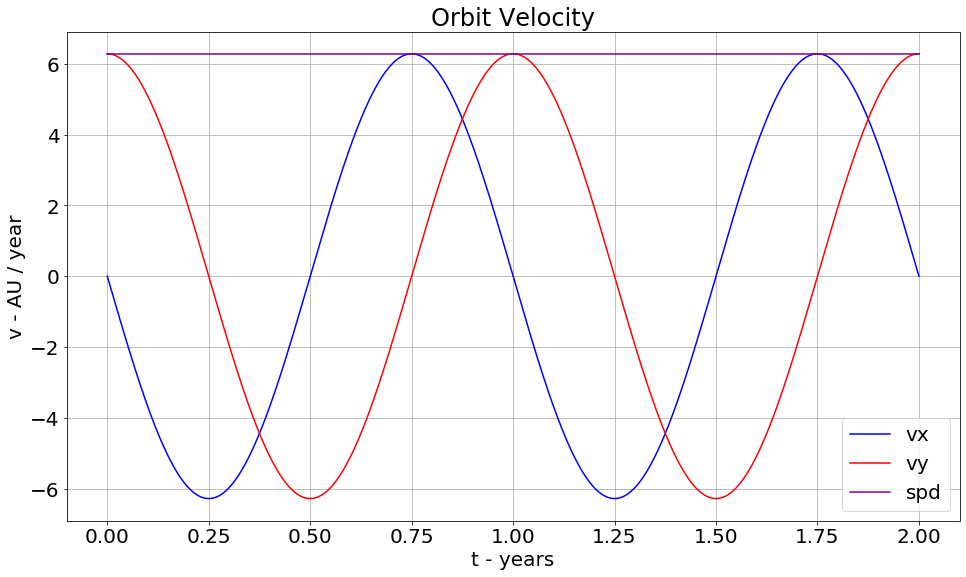

In [9]:
fig, ax = plot_orbit_v(data_earth)

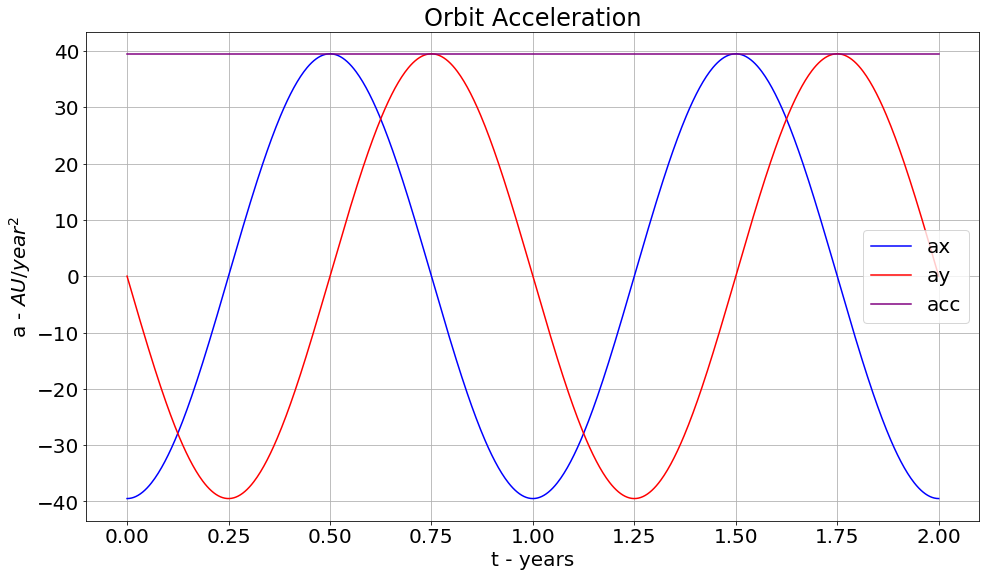

In [10]:
fig, ax = plot_orbit_a(data_earth)

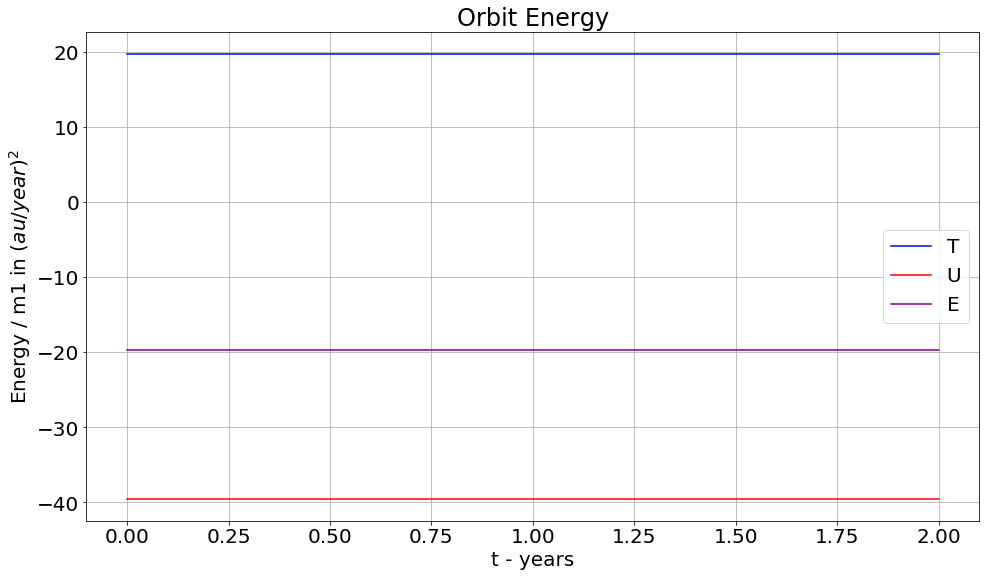

In [11]:
fig, ax = plot_orbit_energy(data_earth)

### Generate data sets and an example batch

In [12]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn, ds_earth_val, ds_earth_tst = make_datasets_earth(n_traj=1000, vt_split=0.20, n_years=2)

# Create DataSet objects for solar system type orbits (a between 0.25 and 32.0)
ds_solar_trn, ds_solar_val, ds_solar_tst = make_datasets_solar(n_traj=100000, vt_split=0.01, n_years=2)

# Create DataSet objects for jupiter orbits only (a=5.2, e=0)
ds_jup_trn, ds_jup_val, ds_jup_tst = make_datasets_r2bc(n_traj=1000, vt_split=0.20, 
                                                        n_years=2, r_min=5.2, r_max=5.2, seed=42, batch_size=64)

In [13]:
# Example batch
batch_in, batch_out = list(ds_earth_val.take(1))[0]
# batch_in.keys()
# batch_out.keys()

t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
mu = batch_in['mu']

q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
H = batch_out['H']
L = batch_out['L']

print(f'Example batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'mu = {mu.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')
# print(f'q0_rec = {q0_rec.shape}')
# print(f'v0_rec = {v0_rec.shape}')
print(f'H  = {H.shape}')
print(f'L  = {L.shape}')

Example batch sizes:
t  = (64, 731)
q0 = (64, 2)
v0 = (64, 2)
mu = (64, 1)
q  = (64, 731, 2)
v  = (64, 731, 2)
a  = (64, 731, 2)
H  = (64, 731)
L  = (64, 731)


In [14]:
batch_size = 64
traj_size = 731

tf.debugging.assert_shapes(
    shapes = {
    # Inputs
    t: (batch_size, traj_size),
    q0: (batch_size, 2),
    v0: (batch_size, 2),
    mu: (batch_size, 1),
    # Outputs
    q: (batch_size, traj_size, 2),
    v: (batch_size, traj_size, 2),
    a: (batch_size, traj_size, 2),
    q0_rec: (batch_size, 2),
    v0_rec: (batch_size, 2),
    H: (batch_size, traj_size),
    L: (batch_size, traj_size),
    })

**Call layers with physics computations**

In [ ]:
T = KineticEnergy_R2BC()(v)
T.shape

In [ ]:
U = PotentialEnergy_R2BC()([q, mu])
U.shape

In [ ]:
L = AngularMomentum_R2BC()([q, v])
L.shape

In [ ]:
L0 = AngularMomentum0_R2BC()([q0, v0])
L0.shape

**Conversion of initial configuration to polar coordinates**

In [ ]:
r0, theta0, omega0 = ConfigToPolar2D()([q0, v0])
print(f'shape of polar batches')
print(f'r0 : {r0.shape}')
print(f'theta0 : {theta0.shape}')
print(f'omega0 : {omega0.shape}')

### Mathematical Model
**Compute position as a function of time from initial polar coordinates**

In [ ]:
position_model_math = make_position_model_r2bc_math(traj_size)

In [ ]:
qx, qy = position_model_math([t, r0, theta0, omega0])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')

In [ ]:
keras.utils.plot_model(position_model_math, './model_plots/position_model_math.png')

In [ ]:
position_model_math.summary()

**Motion Model: Compute v and a from q using automatic differentiation**<br>
Factory function that accepts any position model<br>
Instantiated here from mathematical position model

In [21]:
motion_model_math = Motion_R2BC(position_model=position_model_math, name='motion_model')

NameError: name 'position_model_math' is not defined

In [ ]:
q, v, a = motion_model_math([t, r0, theta0, omega0])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

**Full physics model: computes energy and angular momentum from q, v**<br>
Factory function that accepts any position model.<br>
Instantiated here from mathematical position model.

In [ ]:
model_math = make_model_r2bc_math()

In [ ]:
keras.utils.plot_model(model_math, './model_plots/model_math.png')

In [ ]:
model_math.summary()

## Review outputs of math model

In [ ]:
q, v, a, q0_rec, v0_rec, H, L  = model_math([t, q0, v0, mu])
print(f'model output shapes:')
print(f'q = {q.shape}')
print(f'v = {v.shape}')
print(f'a = {a.shape}')
print(f'q0_rec = {q0_rec.shape}')
print(f'v0_rec = {v0_rec.shape}')
print(f'H = {H.shape}')
print(f'L = {L.shape}')

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1.0E-3)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H'),
        'L': AngularMomentumError(name='L'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'L': 1.0}

In [ ]:
# Compile the mathematical model on a single GPU
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Compile the mathematical model for parallel GPUs
# with strat.scope():
#     model_math_par = make_model_r2bc_analytic()
#     model_math_par.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Evaluate the math model on the earth-like data set
model_math.evaluate(ds_solar_val)

**Timing of math model on single vs. multiple GPU**

In [ ]:
def time_model_eval(model, ds, batches=None, time_mean=None):
    """Time a model to evaluate a dataset"""
    t0 = time.time()
    if batches is None:
        model.evaluate(ds)
    else:
        model.evaluate(ds.take(batches))
    t1 = time.time()
    elapsed = t1 - t0
    print(f'Elapsed Time: {elapsed:5.3f} sec')
    if time_mean is not None:
        delta = (elapsed - time_mean)
        print(f'Time Delta:   {delta:+5.3f} sec')

In [ ]:
# Time the single GPU math model
# time_model_eval(model_math, ds_solar_trn)

In [ ]:
# Time the double GPU math model
# time_model_eval(model_math_par, ds_solar_trn)

## Neural Net Model

In [ ]:
position_model_nn = make_position_model_r2bc_nn([64, 16])

In [ ]:
keras.utils.plot_model(position_model_nn, './model_plots/position_model_nn.png')

In [ ]:
position_model_nn.summary()

In [ ]:
qx, qy = position_model_nn([t, q0, v0, mu])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')

In [ ]:
motion_model_nn = Motion_R2BC(position_model=position_model_nn, name='motion_model_nn')

In [ ]:
q, v, a = motion_model_nn([t, q0, v0, mu])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

### Train the neural net model

In [ ]:
# Make the NN r2bc model
model_nn = make_model_r2bc_nn(hidden_sizes=[64, 16], skip_layers=True, traj_size=traj_size)

In [ ]:
keras.utils.plot_model(model_nn, './model_plots/model_nn.png')

In [ ]:
# model_nn.summary()

In [ ]:
q, v, a, q0_rec, v0_rec, H, L = model_nn([t, q0, v0, mu])
print('shape of model_nn outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')
print(f'q0_rec: {q0_rec.shape}')
print(f'v0_rec: {v0_rec.shape}')
print(f'H: {H.shape}')
print(f'L: {L.shape}')

In [ ]:
# Experiment with learning rate
optimizer = keras.optimizers.Adam(learning_rate=5.0E-4)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=0.010, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'L': AngularMomentumError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'L': 1.0,}

In [ ]:
# Compile the NN model
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Evaluate the NN model on the solar system data set
model_nn.evaluate(ds_solar_val)

In [ ]:
# Set up training
epochs = 40
save_freq = 'epoch'

In [ ]:
hist = compile_and_fit(model=model_nn, 
                       ds=ds_solar_trn, 
                       epochs=epochs,
                       loss=loss, 
                       optimizer=optimizer,
                       metrics=metrics,
                       save_freq=save_freq,
                       prev_history = None)

In [ ]:
fig, ax = plot_loss_hist(hist, '[64, 16]')

In [ ]:
vartbl['hist_model_nn'] = hist
save_vartbl(vartbl, fname)